In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Local CellPLM modules
from CellPLM.model.cellformer import OmicsFormer
from CellPLM.utils.data import TranscriptomicDataset  # assuming your file is in CellPLM/utils/data.py

from CellPLM.utils.data       import TranscriptomicDataset, XDict


/home/hernan_melmoth/anaconda3/envs/cellplm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gene matrix shape: torch.Size([10600, 3000])
Gene names: ['COL1A1', 'COL1A2', 'PPY', 'CTRB1', 'CELA3A', 'CTRB2', 'SPINK1', 'COL3A1', 'CPB1', 'COL6A3']


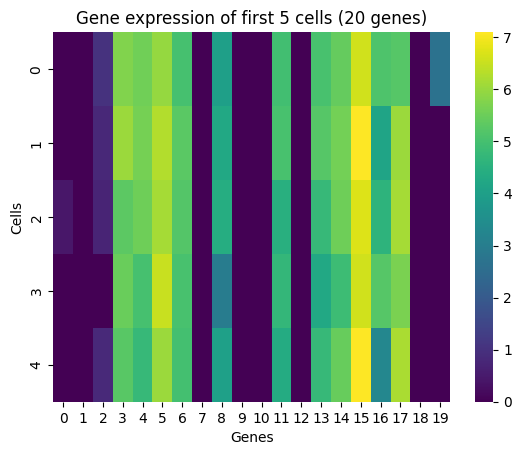

In [25]:
# === Load AnnData ===
adata = sc.read_h5ad("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/CellPLM/CellPLM/data/demo_train.h5ad")

# Show gene matrix (cell x gene)
X = adata.X.todense() if hasattr(adata.X, 'todense') else adata.X
X = torch.FloatTensor(X)

print(f"Gene matrix shape: {X.shape}")  # [num_cells, num_genes]
print("Gene names:", list(adata.var_names[:10]))  # show first 10 genes

# View expression of first 5 cells
sns.heatmap(X[:5, :20], cmap="viridis")
plt.title("Gene expression of first 5 cells (20 genes)")
plt.xlabel("Genes")
plt.ylabel("Cells")
plt.show()


In [26]:
print(X[:5, :20])

tensor([[0.0000, 0.0000, 1.0242, 5.7558, 5.5564, 5.9811, 4.9988, 0.0000, 3.9825,
         0.0000, 0.0000, 4.9368, 0.0000, 5.0343, 5.4298, 6.5833, 5.1179, 5.2146,
         0.0000, 2.6662],
        [0.0000, 0.0000, 0.7811, 6.0262, 5.6276, 6.2843, 5.2888, 0.0000, 4.2521,
         0.0000, 0.0000, 5.0465, 0.0000, 5.2240, 5.5974, 7.0995, 4.1455, 6.0432,
         0.0000, 0.0000],
        [0.4175, 0.0000, 0.7111, 5.3161, 5.5203, 6.1426, 5.2087, 0.0000, 4.3983,
         0.0000, 0.0000, 4.4837, 0.0000, 4.7493, 5.5347, 6.7351, 4.5839, 6.1514,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 5.4804, 5.0040, 6.5013, 5.0304, 0.0000, 2.9402,
         0.0000, 0.0000, 4.6991, 0.0000, 4.2583, 4.8657, 6.5891, 5.2159, 5.6825,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.8198, 5.2516, 4.7531, 6.0238, 4.9822, 0.0000, 3.9953,
         0.0000, 0.0000, 4.3299, 0.0000, 4.7476, 5.4364, 7.0847, 3.2734, 6.2085,
         0.0000, 0.0000]])


In [2]:
train_ds = TranscriptomicDataset(adata, order_required=False)
loader   = DataLoader(train_ds, batch_size=None, shuffle=True, collate_fn=lambda x: x[0])

# --- 2. model ----------------------------------------------------------------
gene_list = adata.var_names.tolist()
model = OmicsFormer(gene_list,
                    enc_mod="transformer",
                    enc_hid=256,
                    enc_layers=4,
                    post_latent_dim=128,
                    dec_mod="mlp",
                    dec_hid=256,
                    dec_layers=2,
                    out_dim=len(gene_list),
                    batch_num=len(train_ds.batch_list),
                    platform_num=len(set(adata.obs["platform"])),
                    pe_type=None,         # <-- disable PE for now
                    cat_pe=False).cuda()

opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6)

# --- 3. training -------------------------------------------------------------
for epoch in range(3):                          # run a few epochs to test
    model.train()
    running = 0
    for data_dict in loader:
        # move tensors to GPU
        for k,v in data_dict.items():
            if torch.is_tensor(v):
                data_dict[k] = v.cuda()
        # dummy gene mask = keep all genes
        data_dict['gene_mask'] = torch.ones(len(gene_list), dtype=torch.bool, device='cuda')

        x_dict = XDict(data_dict)
        _, loss = model(x_dict, data_dict['gene_list'])

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        running += loss.item()

    print(f"Epoch {epoch}   loss = {running / len(loader):.4f}")
    torch.save(model.state_dict(), f"ckpt/epoch-{epoch}.pt")

NameError: name 'adata' is not defined

In [40]:
gene_list = adata.var_names.tolist()
model = OmicsFormer(
        gene_list        = gene_list,
        enc_mod          = "transformer",   # or "flowformer", etc.
        enc_hid          = 128,             # keep small for demo
        enc_layers       = 2,
        post_latent_dim  = 64,
        dec_mod          = "mlp",
        dec_hid          = 128,
        dec_layers       = 2,
        out_dim          = len(gene_list),
        batch_num        = len(ds.batch_list),
        pe_type=None,          # disable positional encodings
        cat_pe=False,          # (must match)
).to("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)


In [42]:
def training_step(x_dict):
    # ❶ Move tensors to device
    device = next(model.parameters()).device
    for k,v in x_dict.items():
        if torch.is_tensor(v):
            x_dict[k] = v.to(device)

    # ❷ The mask builder inside the model needs x_dict['gene_mask'].
    #    For the demo we simply keep every gene.
    if 'gene_mask' not in x_dict:
        x_dict['gene_mask'] = torch.ones(len(gene_list), dtype=torch.bool, device=device)

    # ❸ Forward + loss
    model.train()
    out, loss = model(x_dict)
    return loss, out


In [44]:
from tqdm import tqdm
n_epochs = 1

for epoch in range(n_epochs):
    pbar = tqdm(loader, desc=f"epoch {epoch}")
    for x in pbar:
        optim.zero_grad()
        loss, _ = training_step(x)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})


epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'batch'

In [ ]:

# === Build model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OmicsFormer(
    gene_list=gene_list,
    enc_mod='transformer',
    enc_hid=128,
    enc_layers=3,
    post_latent_dim=64,
    dec_mod='mlp',
    dec_hid=128,
    dec_layers=2,
    out_dim=len(gene_list),
    batch_num=1,
    latent_mod='gmvae',
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Training Loop ===
EPOCHS = 20
os.makedirs("ckpt", exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x = batch['x'].to(device)
        x_dict = {
            'x': x,
            'batch': torch.zeros(x.size(0), dtype=torch.long).to(device)
        }

        x_dict = model.mask_model.apply_mask(x_dict)

        output, loss = model(x_dict)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss / len(dataloader):.4f}")

    # Save model
    torch.save(model.state_dict(), f"ckpt/epoch_{epoch+1}.pt")
